**CS229: Context Learning on Losslessly Compressed Data**

This notebook contains the implementation for my experiments with evaluating the accuracy of BERT on the Words in Context (WiC) dataset, with varying levels of data compression applied to the dataset. I primarily focused on two lossless compression algorithms: Byte-Pair Encoding (BPE) and Huffman Coding. I compressed the WiC dataset with varying levels of tokenization (no tokenization, unigram word tokenization, subword tokenization) and evaluated the resulting trained linear classifier. 

In [1]:
%matplotlib inline

import pickle
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from bpe import get_encoder
from collections import defaultdict
from dahuffman import HuffmanCodec
from hashlib import blake2b
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from transformers import  BertTokenizer, BertModel
from tqdm.notebook import tqdm

2022-12-10 04:05:19.885643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
""" Setup """
torch.manual_seed(2292022)  # CS229, Autumn 2022!

MODEL_DIR = "models/"

SEP_TOKEN = '[SEP] '
CLASSIFICATION_TOKEN = '[CLS]'

VOCAB_SIZE = 29000 # vocab size of BERT
BITS_PER_BYTE = 8

In [3]:
""" Load WiC Dataset """
train_data = pd.read_csv("WiC_dataset/train/train.data.txt", sep="\t", header=None)
train_labels = np.array(open("WiC_dataset/train/train.gold.txt", "r").read().split('\n'))[:-1]  # [:-1] b/c last file entry is a blank line
valid_data = pd.read_csv("WiC_dataset/dev/dev.data.txt", sep="\t", header=None)
valid_labels = np.array(open("WiC_dataset/dev/dev.gold.txt", "r").read().split('\n'))[:-1]

In [4]:
# see what the training data looks like
train_data

,0,1,2,3,4
0,carry,V,2-1,You must carry your camping gear .,Sound carries well over water .
1,go,V,2-6,Messages must go through diplomatic channels .,Do you think the sofa will go through the door ?
2,break,V,0-2,Break an alibi .,The wholesaler broke the container loads into ...
3,cup,N,8-4,He wore a jock strap with a metal cup .,Bees filled the waxen cups with honey .
4,academy,N,1-2,The Academy of Music .,The French Academy .
...,...,...,...,...,...
5423,krona,N,4-8,Piecas kronas — five krona .,Kronas kurss — the exchange rate of the krona .
5424,conflict,N,3-1,The harder the conflict the more glorious the ...,The conflict between the government and the re...
5425,answer,V,0-0,Answer the riddle .,Answer a question .
5426,play,V,0-0,Play the casinos in Trouville .,Play the races .


In [5]:
""" Load Pre-Trained BERT Model and Tokenizer """
model = BertModel.from_pretrained('bert-large-uncased')
pretrained_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

cls_id = pretrained_tokenizer.convert_tokens_to_ids('[CLS]')
sep_id = pretrained_tokenizer.convert_tokens_to_ids('[SEP]')

""" Train Tokenizers/Encoders on our Training Data """
# corpus containing the raw text of the training set
train_corpus = ' '.join(train_data[3].tolist()) + ' ' + ' '.join(train_data[4].tolist())

# BPE encoder
bpe_tokenizer_encoder = get_encoder()

# BPE tokenizer (used to calculate compression for long strings)
bpe_tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
bpe_tokenizer.pre_tokenizer = Whitespace()
bpe_tokenizer.train_from_iterator(train_corpus)

# Huffman codec trained over training set text
letter_freq = defaultdict(int)
for letter in train_corpus:
    letter_freq[letter] += 1
codec_with_spaces = HuffmanCodec.from_frequencies(letter_freq)
codec_without_spaces = HuffmanCodec.from_frequencies({k: v for k, v in letter_freq.items() if k != ' '})

# Huffman codec for text broken up by BERT tokenizer
subword_letter_freq = defaultdict(int)
for i in range(len(train_data)):
    tokenized_example = pretrained_tokenizer.tokenize(train_data[3][i])
    for token in tokenized_example:
        for letter in token:
            subword_letter_freq[letter] += 1
    tokenized_example = pretrained_tokenizer.tokenize(train_data[4][i])
    for token in tokenized_example:
        for letter in token:
            subword_letter_freq[letter] += 1
subword_codec = HuffmanCodec.from_data(subword_letter_freq)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
""" Util for splitting compressed sentences into an array of integers """
# BERT has a stated vocab size of 30,000, which means that each token index has to be encoded using 14 bits
# (log2(30000) = 14.9) to fit within the encoding range.

# We thus "break up" longer words into subwords, and use the subword vocab to encode the subwords of 14 bits each.
def compress_tokens_into_vocab(token_list, max_bits = int(np.floor(np.log2(VOCAB_SIZE)))):
    compressed_tokens = []
    for token in token_list:
        if token < VOCAB_SIZE:
            compressed_tokens.append(token)
        else:
            binary_rep = bin(token)[2:]
            while len(binary_rep) > max_bits:
                compressed_tokens.append(int(binary_rep[len(binary_rep)-max_bits:], 2))
                binary_rep = binary_rep[:-1 * max_bits]
            compressed_tokens.append(int(binary_rep, 2))
    return compressed_tokens

# sanity check
# compress_tokens_into_vocab([41000, 12341234123, 5, 1341234123412])


In [7]:
def run_experiment(model, encoding_func, train_data, train_labels, valid_data, valid_labels):
    """
    General function to run an experiment on a given model and encoding function.

    The encoding function maps string data to an array of ints. It is intended that when testing
    different compression methods, we build in this compression into the encoding functions.
    """
    train_indexed_tokens = encoding_func(train_data)
    train_segments_ids = [[1] * len(example) for example in train_indexed_tokens]

    # Convert inputs to PyTorch tensors
    train_tokens_tensor = [torch.tensor([example]) for example in train_indexed_tokens]
    train_segments_tensors = [torch.tensor([seg_id]) for seg_id in train_segments_ids]
    print(f"Sample indexed token for {encoding_func.__name__}: {train_indexed_tokens[0]}")

    # get sentence embedding from BERT hidden states
    sentence_embeddings = []
    print("Now evaluating pre-trained BERT model on training set")
    for i in tqdm(range(len(train_tokens_tensor)), desc="Train Progress"):
        embedding = model.forward(train_tokens_tensor[i], train_segments_tensors[i])
        sentence_embeddings.append(embedding[0][0][0].detach().numpy()) # reshape into 1D array
    sentence_embeddings = np.array(sentence_embeddings)
    
    # train a logistic classifier on the sentence embeddings with labels
    x_train, x_test, y_train, y_test = train_test_split(sentence_embeddings, train_labels, test_size=0.2, random_state=42)
    clf = LogisticRegression(random_state=0).fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    train_acc = accuracy_score(y_test, y_pred)
    # save model
    with open(f'{MODEL_DIR}{encoding_func.__name__}.pkl','wb') as f:
        pickle.dump(clf,f)

    # evaluate on the dev set
    test_indexed_tokens = encoding_func(valid_data)
    test_segments_ids = [[1] * len(example) for example in test_indexed_tokens]
    test_tokens_tensor = [torch.tensor([example]) for example in test_indexed_tokens]
    test_segments_tensors = [torch.tensor([seg_id]) for seg_id in test_segments_ids]

    results = []
    print("Now evaluating pre-trained BERT model on the validation set")
    for i in tqdm(range(len(test_tokens_tensor)), desc="Validation Progress"):
        embedding = model.forward(test_tokens_tensor[i], test_segments_tensors[i])
        results.append(embedding[0][0][0].detach().numpy())
    y_pred = clf.predict(results)
    test_acc = accuracy_score(valid_labels, y_pred)

    print("Training accuracy: ", train_acc)
    print("Validation accuracy: ", test_acc)
    
    return clf, train_acc, test_acc


|**EXPERIMENTS**|
|---------------|

In [8]:
"""
Experiment 1: Pre-trained BERT tokenizer with subword tokenization (no compression)
"""
def pretrained_subword_encoder(data):
    sent1_col = data[3].tolist()
    sent2_col = data[4].tolist()
    # formats our sentence pairs into a format that can be input into BERT.
    # [CLS] sentence1 [SEP] sentence2 [SEP]
    modif_data = [CLASSIFICATION_TOKEN + ' ' + sent1_col[i] + ' ' + SEP_TOKEN + ' ' + sent2_col[i] + ' ' + SEP_TOKEN for i in range(len(sent1_col))]
    # Tokenize our sentence with the pre-trained BERT tokenizer.
    tokenized_data = [pretrained_tokenizer.tokenize(example) for example in modif_data]
    # Map the token strings to their vocabulary indices.
    return [pretrained_tokenizer.convert_tokens_to_ids(example) for example in tokenized_data]

pretrained_clf, pretrained_train_acc, pretrained_test_acc = run_experiment(model, pretrained_subword_encoder, train_data, train_labels, valid_data, valid_labels)


Sample indexed token for pretrained_subword_encoder: [101, 2017, 2442, 4287, 2115, 13215, 6718, 1012, 102, 2614, 7883, 2092, 2058, 2300, 1012, 102]
Now evaluating pre-trained BERT model on training set
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Train Progress:   0%|          | 0/5428 [00:00<?, ?it/s]

/Users/matthewding/Documents/GitHub/cs229-final-project/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now evaluating pre-trained BERT model on the validation set


Validation Progress:   0%|          | 0/638 [00:00<?, ?it/s]

Training accuracy:  0.6620626151012892
Validation accuracy:  0.6253918495297806


In [9]:
"""
Experiment 2a: Byte-Pair Encoding (BPE) of entire string
"""
def bpe_sentence_encoder(data):
    sent1_col = data[3].tolist()
    sent2_col = data[4].tolist()
    return [[cls_id] + compress_tokens_into_vocab(bpe_tokenizer_encoder.encode(sent1_col[i])) + [sep_id] + compress_tokens_into_vocab(bpe_tokenizer_encoder.encode(sent2_col[i])) + [sep_id] for i in range(len(sent1_col))]

bpe_sentence_clf, bpe_sentence_train_acc, bpe_sentence_test_acc = run_experiment(model, bpe_sentence_encoder, train_data, train_labels, valid_data, valid_labels)

Sample indexed token for bpe_sentence_encoder: [101, 1639, 1276, 3283, 534, 22498, 7733, 764, 102, 21369, 10732, 880, 625, 1660, 764, 102]
Now evaluating pre-trained BERT model on training set


Train Progress:   0%|          | 0/5428 [00:00<?, ?it/s]

Now evaluating pre-trained BERT model on the validation set


/Users/matthewding/Documents/GitHub/cs229-final-project/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Progress:   0%|          | 0/638 [00:00<?, ?it/s]

Training accuracy:  0.5368324125230203
Validation accuracy:  0.5282131661442007


In [10]:
"""
Experiment 2b: BPE of individual words
"""
def bpe_word_encoder(data):
    sent1_col = data[3].tolist()
    sent2_col = data[4].tolist()
    bpe_encoded_words = []
    for i in range(len(sent1_col)):
        curr_token = [cls_id]
        for word in sent1_col[i].split():
            curr_token += [token % VOCAB_SIZE for token in bpe_tokenizer_encoder.encode(word)]
        curr_token += [sep_id]
        for word in sent2_col[i].split():
            curr_token += [token % VOCAB_SIZE for token in bpe_tokenizer_encoder.encode(word)]
        curr_token += [sep_id]
        bpe_encoded_words.append(curr_token)
    return bpe_encoded_words

bpe_word_clf, bpe_word_train_acc, bpe_word_test_acc = run_experiment(model, bpe_word_encoder, train_data, train_labels, valid_data, valid_labels)

Sample indexed token for bpe_word_encoder: [101, 1639, 27238, 5993, 14108, 16544, 278, 2763, 13, 102, 21369, 7718, 1678, 4053, 2502, 7050, 13, 102]
Now evaluating pre-trained BERT model on training set


Train Progress:   0%|          | 0/5428 [00:00<?, ?it/s]

Now evaluating pre-trained BERT model on the validation set


/Users/matthewding/Documents/GitHub/cs229-final-project/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Progress:   0%|          | 0/638 [00:00<?, ?it/s]

Training accuracy:  0.5662983425414365
Validation accuracy:  0.49843260188087773


In [11]:
"""
Experiment 2c: BPE of subwords using pre-trained BERT tokenizer
"""
def bpe_subword_encoder(data):
    sent1_col = [pretrained_tokenizer.tokenize(example) for example in data[3].tolist()]
    sent2_col = [pretrained_tokenizer.tokenize(example) for example in data[4].tolist()]
    bpe_encoded_tokens = []
    for i in range(len(sent1_col)):
        curr_token = [cls_id]
        for word in sent1_col[i]:
            curr_token += [token % VOCAB_SIZE for token in bpe_tokenizer_encoder.encode(word)]
        curr_token += [sep_id]
        for word in sent2_col[i]:
            curr_token += [token % VOCAB_SIZE for token in bpe_tokenizer_encoder.encode(word)]
        curr_token += [sep_id]
        bpe_encoded_tokens.append(curr_token)
    return bpe_encoded_tokens

bpe_subword_clf, bpe_subword_train_acc, bpe_subword_test_acc = run_experiment(model, bpe_subword_encoder, train_data, train_labels, valid_data, valid_labels)

Sample indexed token for bpe_subword_encoder: [101, 5832, 27238, 5993, 14108, 16544, 278, 2763, 13, 102, 23661, 7718, 1678, 4053, 2502, 7050, 13, 102]
Now evaluating pre-trained BERT model on training set


Train Progress:   0%|          | 0/5428 [00:00<?, ?it/s]

/Users/matthewding/Documents/GitHub/cs229-final-project/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now evaluating pre-trained BERT model on the validation set


Validation Progress:   0%|          | 0/638 [00:00<?, ?it/s]

Training accuracy:  0.5755064456721916
Validation accuracy:  0.5156739811912225


In [12]:
"""
Experiment 3a: Huffman coding of entire string, breaking bitstring into smaller strings
"""
def huffman_sentence_encoder(data):
    sent1_col = data[3].tolist()
    sent2_col = data[4].tolist()
    return [[cls_id] + compress_tokens_into_vocab([int.from_bytes(codec_with_spaces.encode(sent1_col[i]), byteorder=sys.byteorder)]) + [sep_id] + compress_tokens_into_vocab([int.from_bytes(codec_with_spaces.encode(sent2_col[i]), byteorder=sys.byteorder)]) + [sep_id] for i in range(len(sent1_col))]

huffman_sentence_clf, huffman_sentence_train_acc, huffman_sentence_test_acc = run_experiment(model, huffman_sentence_encoder, train_data, train_labels, valid_data, valid_labels)

Sample indexed token for huffman_sentence_encoder: [101, 13221, 14957, 14296, 5677, 3815, 12600, 16265, 1594, 16337, 14459, 4665, 3362, 102, 3778, 11769, 15042, 10204, 3357, 11349, 12906, 1233, 1890, 9291, 6, 102]
Now evaluating pre-trained BERT model on training set


Train Progress:   0%|          | 0/5428 [00:00<?, ?it/s]

Now evaluating pre-trained BERT model on the validation set


/Users/matthewding/Documents/GitHub/cs229-final-project/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Progress:   0%|          | 0/638 [00:00<?, ?it/s]

Training accuracy:  0.5331491712707183
Validation accuracy:  0.512539184952978


In [13]:
"""
Experiment 3b: Huffman coding of individual words
"""
def huffman_word_encoder(data):
    sent1_col = data[3].tolist()
    sent2_col = data[4].tolist()
    huffman_encoded_words = []
    for i in range(len(sent1_col)):
        curr_token = [cls_id]
        for word in sent1_col[i].split():
            curr_token.append(int.from_bytes(codec_without_spaces.encode(word), byteorder=sys.byteorder) % VOCAB_SIZE)
        curr_token.append(sep_id)
        for word in sent2_col[i].split():
            curr_token.append(int.from_bytes(codec_without_spaces.encode(word), byteorder=sys.byteorder) % VOCAB_SIZE)
        curr_token.append(sep_id)
        huffman_encoded_words.append(curr_token)
    return huffman_encoded_words

huffman_word_clf, huffman_word_train_acc, huffman_word_test_acc = run_experiment(model, huffman_word_encoder, train_data, train_labels, valid_data, valid_labels)

Sample indexed token for huffman_word_encoder: [101, 2261, 3784, 6062, 26859, 20806, 23462, 161, 102, 5292, 26622, 19550, 22587, 3743, 161, 102]
Now evaluating pre-trained BERT model on training set


Train Progress:   0%|          | 0/5428 [00:00<?, ?it/s]

Now evaluating pre-trained BERT model on the validation set


/Users/matthewding/Documents/GitHub/cs229-final-project/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Progress:   0%|          | 0/638 [00:00<?, ?it/s]

Training accuracy:  0.5681399631675875
Validation accuracy:  0.5188087774294671


In [14]:
"""
Experiment 3c: Huffman coding of tokenized words (using pretrained tokenizer)
"""
def huffman_subword_encoder(data):
    sent1_col = [pretrained_tokenizer.tokenize(example) for example in data[3].tolist()]
    sent2_col = [pretrained_tokenizer.tokenize(example) for example in data[4].tolist()]
    huffman_encoded_subwords = []
    for i in range(len(sent1_col)):
        curr_token = [cls_id]
        for word in sent1_col[i]:
            curr_token.append(int.from_bytes(subword_codec.encode(word), byteorder=sys.byteorder) % VOCAB_SIZE)
        curr_token.append(sep_id)
        for word in sent2_col[i]:
            curr_token.append(int.from_bytes(subword_codec.encode(word), byteorder=sys.byteorder) % VOCAB_SIZE)
        curr_token.append(sep_id)
        huffman_encoded_subwords.append(curr_token)
    return huffman_encoded_subwords

huffman_subword_clf, huffman_subword_train_acc, huffman_subword_test_acc = run_experiment(model, huffman_subword_encoder, train_data, train_labels, valid_data, valid_labels)

Sample indexed token for huffman_subword_encoder: [101, 18875, 24760, 18950, 11155, 22430, 8986, 87, 102, 27605, 27558, 12534, 17722, 12023, 87, 102]
Now evaluating pre-trained BERT model on training set


Train Progress:   0%|          | 0/5428 [00:00<?, ?it/s]

/Users/matthewding/Documents/GitHub/cs229-final-project/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now evaluating pre-trained BERT model on the validation set


Validation Progress:   0%|          | 0/638 [00:00<?, ?it/s]

Training accuracy:  0.58195211786372
Validation accuracy:  0.5094043887147336


|**ANALYSIS AND RESULT VISUALIZATION**|
|-------------------------------------|

In [15]:
"""
Compression Algorithms and Trained Models

The algos/models's indices match each other. So trained_models[i] contains the model that was trained with the compression algorithm in encoders[i]
"""
encoders = [pretrained_subword_encoder, bpe_sentence_encoder, bpe_sentence_encoder, bpe_subword_encoder, huffman_sentence_encoder, huffman_word_encoder, huffman_subword_encoder]
trained_models = [pretrained_clf, bpe_sentence_clf, bpe_sentence_clf, bpe_subword_clf, huffman_sentence_clf, huffman_word_clf, huffman_subword_clf]
test_accs = [pretrained_test_acc, bpe_sentence_test_acc, bpe_sentence_test_acc, bpe_subword_test_acc, huffman_sentence_test_acc, huffman_word_test_acc, huffman_subword_test_acc]
labels = ["uncompressed", "BPE-sentence", "BPE-word", "BPE-subword", "Huffman-sentence", "Huffman-word", "Huffman-subword"]

encoders_dict = {labels[i]: encoders[i] for i in range(len(labels))}
trained_models_dict = {labels[i]: trained_models[i] for i in range(len(labels))}

In [24]:
"""
This code contains the functions for compressing the training data and computing the compression ratio
"""

def compute_compression_percentages(data):
    """ All sizes are in units of bits"""
    full_text = ' '.join(data[3].tolist()) + ' ' + ' '.join(data[4].tolist())
    words = full_text.split()
    subword_tokens = pretrained_tokenizer.tokenize(full_text)

    data_sizes = {}
    compression_factors = {}
    # uncompressed_data (no tokenization)
    uncompressed_size = len(full_text) * BITS_PER_BYTE
    data_sizes["uncompressed"] = uncompressed_size
    compression_factors["uncompressed"] = 0
    # BPE (sentences)
    bpe_sentence_size = len(bpe_tokenizer.encode(full_text).tokens) * BITS_PER_BYTE
    data_sizes["BPE-sentence"] = bpe_sentence_size
    compression_factors["BPE-sentence"] = (uncompressed_size - bpe_sentence_size) / uncompressed_size
    # BPE (words)
    bpe_word_size = sum([len(bpe_tokenizer_encoder.bpe(word)) for word in words]) * BITS_PER_BYTE
    data_sizes["BPE-word"] = bpe_word_size
    compression_factors["BPE-word"] = (uncompressed_size - bpe_word_size) / uncompressed_size
    # BPE (subword tokens)
    bpe_subword_size = sum([len(bpe_tokenizer_encoder.bpe(token)) for token in subword_tokens]) * BITS_PER_BYTE
    data_sizes["BPE-subword"] = bpe_subword_size
    compression_factors["BPE-subword"] = (uncompressed_size - bpe_subword_size) / uncompressed_size
    # Huffman encoding (sentences)
    huffman_sentence_size = len(codec_with_spaces.encode(full_text)) * BITS_PER_BYTE
    data_sizes["Huffman-sentence"] = huffman_sentence_size
    compression_factors["Huffman-sentence"] = (uncompressed_size - huffman_sentence_size) / uncompressed_size
    # Huffman encoding (words)
    huffman_word_size = sum([len(codec_without_spaces.encode(word)) for word in words]) * BITS_PER_BYTE
    data_sizes["Huffman-word"] = huffman_word_size
    compression_factors["Huffman-word"] = (uncompressed_size - huffman_word_size) / uncompressed_size
    # Huffman encoding (subword tokens)
    huffman_subword_size = sum([len(subword_codec.encode(token)) for token in subword_tokens]) * BITS_PER_BYTE
    data_sizes["Huffman-subword"] = huffman_subword_size
    compression_factors["Huffman-subword"] = (uncompressed_size - huffman_subword_size) / uncompressed_size

    return data_sizes, compression_factors

In [25]:
_, test_compression_factors = compute_compression_percentages(valid_data)
test_compression_factors

{'uncompressed': 0,
 'BPE-sentence': 0.1978439499709133,
 'BPE-word': 0.14367001163467133,
 'BPE-subword': 0.11222004072134963,
 'Huffman-sentence': 0.45426119837114604,
 'Huffman-word': 0.4631326352530541,
 'Huffman-subword': 0.44968004653868526}

/var/folders/47/7cyx1m3x64s2dgtkc9jm0kkc0000gn/T/ipykernel_32652/156965073.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_extended, np.polyval(p1,x_extended),'r-', label="Best Fit (excluding uncompressed)", c='black')


Line of best fit: y = -0.03x + 0.53


<Figure size 640x480 with 0 Axes>

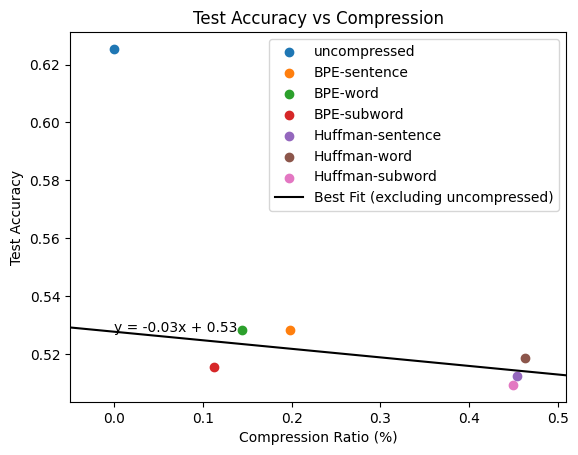

In [34]:
# plot model accuracies vs compression ratio
plt.clf()
fig, ax = plt.subplots()
x, y = [], []
for i in range(len(labels)):
    label = labels[i]
    plt.scatter(test_compression_factors[label], test_accs[i], label=label)
    if label == "uncompressed":
        continue
    x.append(test_compression_factors[label])
    y.append(test_accs[i])

# plot line of best fit (across entire graph)
x_low = -0.05
x_high = 1.1*max(list(test_compression_factors.values()))
x_extended = np.linspace(x_low, x_high, 100)
p1 = np.polyfit(x, y, 1)
ax.annotate(f"y = {round(p1[0], 2)}x + {round(p1[1], 2)}", (0, p1[1]))
plt.plot(x_extended, np.polyval(p1,x_extended),'r-', label="Best Fit (excluding uncompressed)", c='black')
print(f"Line of best fit: y = {round(p1[0], 2)}x + {round(p1[1], 2)}")
plt.xlim(x_low, x_high)

plt.title("Test Accuracy vs Compression")
plt.xlabel("Compression Ratio (%)")
plt.ylabel("Test Accuracy")
plt.legend()
plt.savefig("figures/test_accuracies.png")